In [1]:
#import necessary packages
import pystan
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
import pandas as pd
import seaborn
import math

%matplotlib inline

In [2]:
#read data into notebook
data = pd.read_csv('weekly_in_situ_co2_mlo.csv',header=None,skiprows=44)

from datetime import *
#define function to find days between two dates
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

#create array of t values
days= np.zeros(len(data))
for i in range(0,len(data)):
    days[i]=days_between(data[0][0],data[0][i])

#add t as a column to dataframe
data[2] = days

In [3]:
#define the data to feed into the stan model
co2_data = {
    'N': len(data),
    'days': data[2],
    'co2': data[1],
    'n_future': 40*52
}

In [4]:
#stan model according to example given
stan_code = """

data {
    int<lower=1> N; // number of observations
    real<lower=0> days[N]; // days passed from initial observation
    real<lower=0> co2[N]; // co2 measurement for each observation
    int<lower=1> n_future;
}

parameters {
    real<lower=0> intercept;
    real<lower=0> slope;
    real<lower=0> c2;
    real<lower=0> c3_x;
    real<lower=0> c3_y;    
    real<lower=0> sigma;
}

transformed parameters {
    real<lower=0,upper=1> c3;
    c3 = 2*pi()*atan2(c3_x,c3_y)/(2*pi())+0.5;
}

model {
    intercept ~ normal(300,10);
    slope ~ gamma(0.005,0.0005);
    c2 ~ gamma(1,0.5);
    c3_x ~ normal(0,1);
    c3_y ~ normal(0,1);
    sigma ~ gamma(1,0.5);
    for(i in 1:N){
        co2[i] ~ normal((intercept+slope*days[i] + c2*cos((2*pi()*days[i])/365.25+c3)),sigma);
    }
}

generated quantities {
    real x_future[n_future+1];
    for(i in 1:n_future+1) {
        x_future[i] = normal_rng(
        intercept+slope*(days[N]+(i-1)*7) + c2*cos((2*pi()*(days[N]+(i-1)*7)/365.25+c3)),sigma);
    }
}
"""

In [5]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ac1b5ca1500a86d183a211e48315cd85 NOW.


In [6]:
parameters = ['intercept','slope','c2','c3','sigma']
results = stan_model.sampling(data=co2_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_ac1b5ca1500a86d183a211e48315cd85.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept 306.37  2.2e-3   0.14 306.09 306.27 306.37 306.46 306.65   4337    1.0
slope     4.3e-3  1.7e-7 1.1e-5 4.2e-3 4.3e-3 4.3e-3 4.3e-3 4.3e-3   4439    1.0
c2          1.69  2.1e-3    0.1    1.5   1.62   1.69   1.76   1.88   2306    1.0
c3           0.5  4.3e-5 2.6e-3    0.5    0.5    0.5    0.5   0.51   3543    1.0
sigma       3.95  1.1e-3   0.05   3.85   3.92   3.95   3.99   4.06   2152    1.0

Samples were drawn using NUTS at Thu Mar  7 21:10:05 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


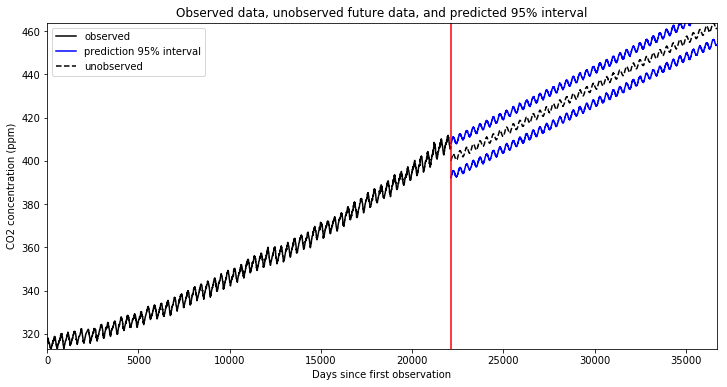

In [7]:
#extracting values required for plotting predicted values from stan generated quantities
means = [np.mean(samples['x_future'][:,i]) for i in range(0,2081)]
percentiles = [np.percentile(samples['x_future'][:,i],q=[2.5,97.5]) for i in range(0,2081)]
lower_bound = [item[0] for item in percentiles]
upper_bound = [item[1] for item in percentiles]

#determine info needed for plotting
n = len(data)-1
x_future_values = np.arange(data[2][n], data[2][n] + 2080*7 +1,7)
n_future = 40*52

plt.figure(figsize=(12, 6))

#plot the original data
plt.plot(data[2], data[1], 'k-', label='observed')

#plot reasonable range for axes
plt.xlim(0, data[2][n] + n_future*7 + 1)
plt.ylim(
    min(min(means), min(data[1])),
    max(max(means), max(data[1])))

#plot lower bound of confidence intervals
plt.plot(
    x_future_values,lower_bound,
    'b-', label='prediction 95% interval')

#plot upper bound of confidence intervals
plt.plot(
    x_future_values,
    upper_bound,
    'b-')

#plot mean of predicted values from stan
plt.plot(
    x_future_values,means, 'k--',label='unobserved')

#indicate where values change from observed to unobserved
plt.axvline(data[2][n], color='red')

#create labels and legend
plt.xlabel('Days since first observation')
plt.ylabel('CO2 concentration (ppm)')
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()

In [8]:
#separate year, month and day from date data in case needed
data['Year'] = [d.split('-')[0] for d in data[0]]
data['Month'] = [d.split('-')[1] for d in data[0]]
data['Day'] = [d.split('-')[2] for d in data[0]]

In [9]:
#improvement on example code by changing from linear to 2nd order polynomial
better_code = """

data {
    int<lower=1> N; // number of observations
    real<lower=0> days[N]; // days passed from initial observation
    real<lower=0> co2[N]; // co2 measurement for each observation
    int<lower=1> n_future;
}

parameters {
    real<lower=0> intercept;
    real<lower=0> x_1;
    real<lower=0> x_2;
    real<lower=0> c2;
    real<lower=0> c3_x;
    real<lower=0> c3_y;    
    real<lower=0> sigma;
}

transformed parameters {
    real c3;
    c3 = atan2(c3_x,c3_y);
}

model {
    intercept ~ normal(300,10);
    x_1 ~ gamma(1,0.5);
    x_2 ~ gamma(1,0.5);
    c2 ~ gamma(1,0.5);
    c3_x ~ normal(0,1);
    c3_y ~ normal(0,1);
    sigma ~ gamma(1,0.5);
    for(i in 1:N){
        co2[i] ~ normal(intercept +x_1*days[i] + x_2*days[i]^2 + c2*cos((2*pi()*days[i])/365.25+c3),sigma);
    }
}

generated quantities {
    real x_future[n_future+1];
    for(i in 1:n_future+1) {
        x_future[i] = normal_rng(
        intercept+x_1*(days[N]+(i-1)*7) + x_2*(days[N]+(i-1)*7)^2 + c2*cos(2*pi()*(days[N]+(i-1)*7)/365.25+c3),sigma);
    }
}
"""

In [10]:
better_model = pystan.StanModel(model_code=better_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_17d6932062dd14845567dcf02badb9a1 NOW.


In [11]:
parameters = ['intercept','x_1','x_2','c2','c3','sigma']
better_results = better_model.sampling(data=co2_data)
print(better_results.stansummary(pars=parameters))

better_samples = better_results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_17d6932062dd14845567dcf02badb9a1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept 314.52  1.6e-3   0.07 314.38 314.47 314.52 314.57 314.66   2183    1.0
x_1       2.1e-3  3.7e-7 1.5e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.2e-3   1586    1.0
x_2       9.6e-8 1.7e-116.4e-10 9.5e-8 9.6e-8 9.6e-8 9.6e-8 9.7e-8   1458    1.0
c2          2.61  6.0e-4   0.03   2.55   2.59   2.61   2.64   2.68   2945    1.0
c3        3.5e-4  5.4e-6 3.4e-4 8.1e-6 9.9e-5 2.5e-4 4.9e-4 1.3e-3   4095    1.0
sigma       1.27  3.2e-4   0.02   1.24   1.26   1.27   1.28   1.31   2513    1.0

Samples were drawn using NUTS at Thu Mar  7 21:24:33 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


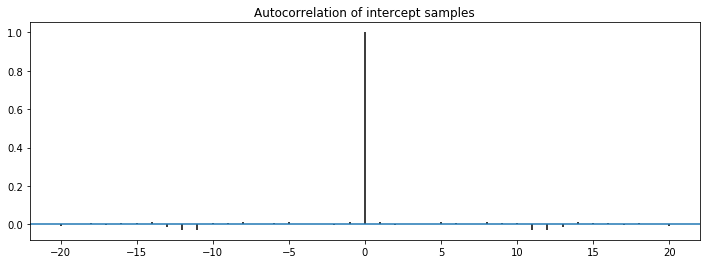

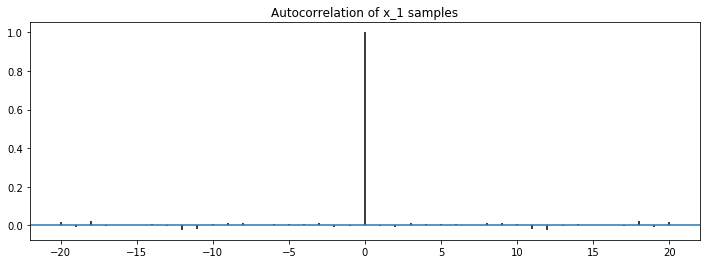

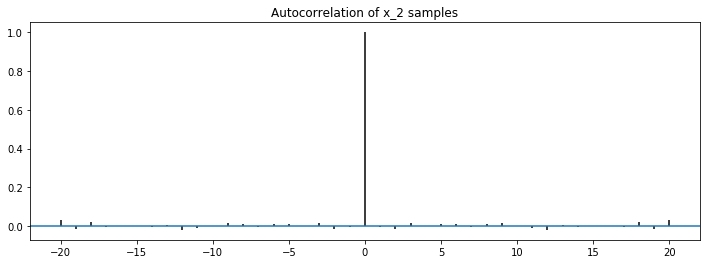

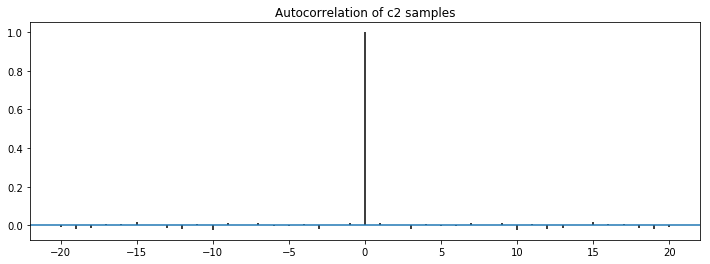

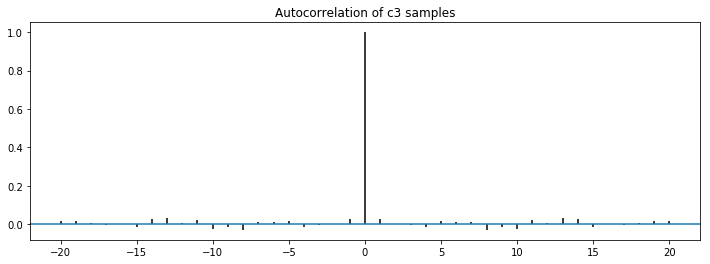

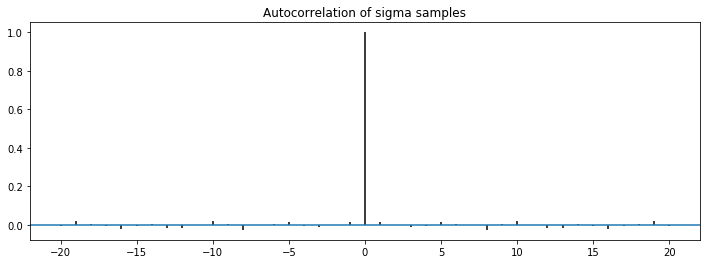

In [12]:
#autocorrelation for example model
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(better_samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

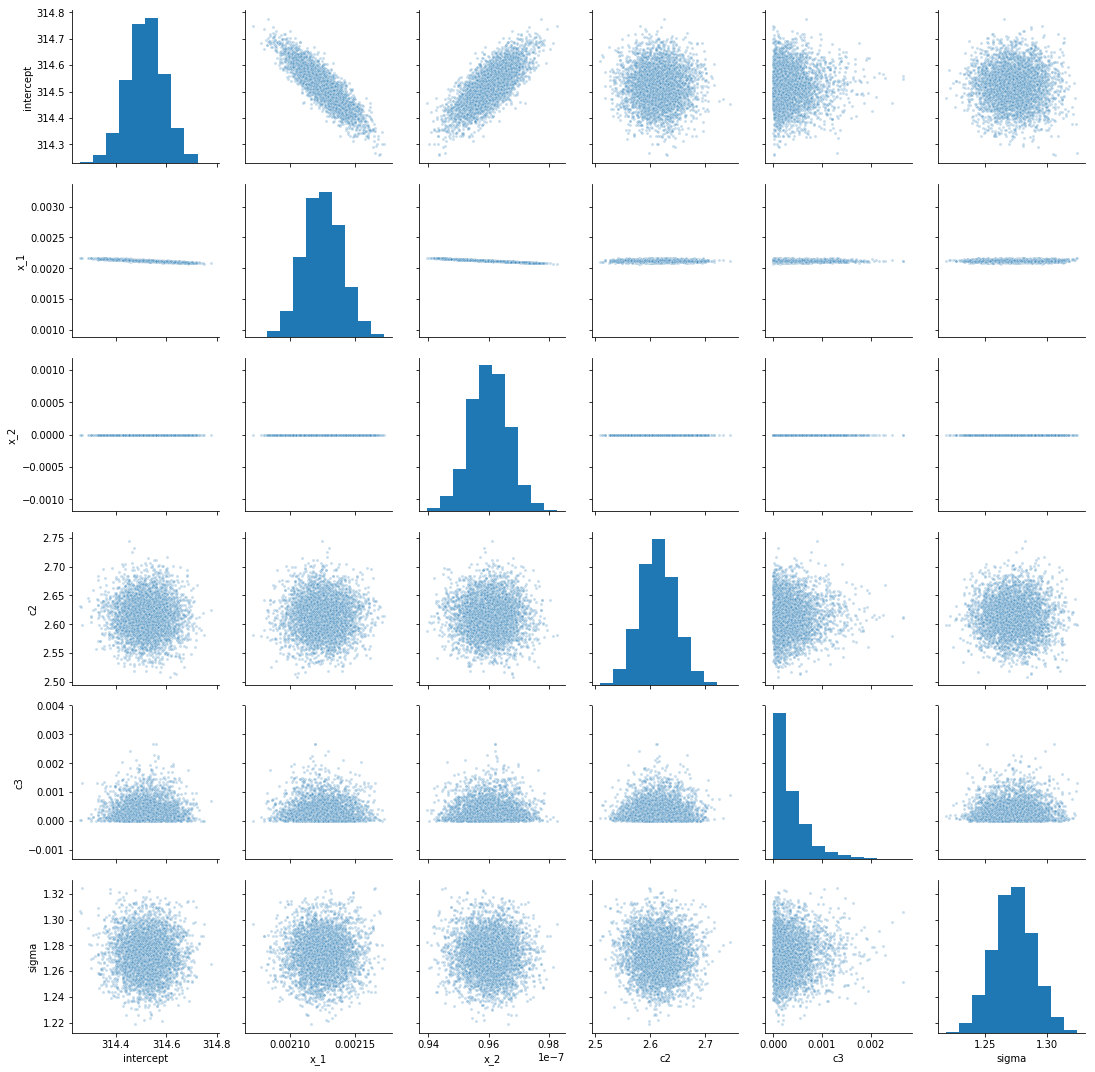

In [13]:
#pair plots for example model
df = pd.DataFrame(
    data=np.transpose([better_samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

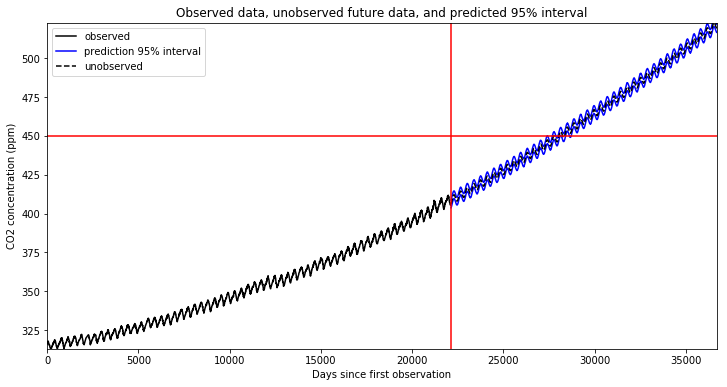

In [14]:
#finding values required for plotting predicted values from stan generated quantities
#same methods as above but for improved model
means = [np.mean(better_samples['x_future'][:,i]) for i in range(0,2081)]
percentiles = [np.percentile(better_samples['x_future'][:,i],q=[2.5,97.5]) for i in range(0,2081)]
lower_bound = [item[0] for item in percentiles]
upper_bound = [item[1] for item in percentiles]

n = len(data)-1
x_future_values = np.arange(data[2][n], data[2][n] + 2080*7 +1,7)
n_future = 40*52

plt.figure(figsize=(12, 6))
plt.plot(data[2], data[1], 'k-', label='observed')
plt.xlim(0, data[2][n] + n_future*7 + 1)
plt.ylim(
    min(min(means), min(data[1])),
    max(max(means), max(data[1])))
plt.plot(
    x_future_values,lower_bound,
    'b-', label='prediction 95% interval')
plt.plot(
    x_future_values,
    upper_bound,
    'b-')
plt.plot(
    x_future_values,means, 'k--',label='unobserved')
plt.axvline(data[2][n], color='red')

#additional line to show high risk ppm value
plt.axhline(450,color='red')
plt.xlabel('Days since first observation')
plt.ylabel('CO2 concentration (ppm)')
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()

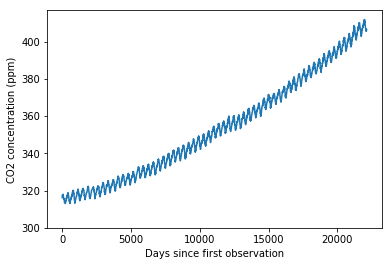

In [15]:
#plot of observed data
plt.plot(data[2],data[1])
plt.xticks(np.arange(0,data[2][3090],5000))
plt.ylim(300,)
plt.xlabel('Days since first observation')
plt.ylabel('CO2 concentration (ppm)')
plt.show()

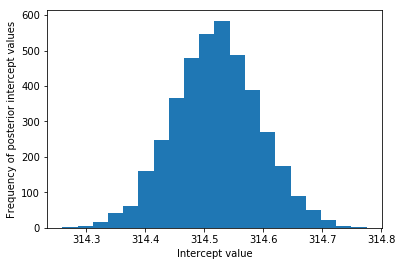

In [16]:
#first of posterior sample plots, continued
plt.hist(better_samples['intercept'],bins=20)
plt.xlabel('Intercept value')
plt.ylabel('Frequency of posterior intercept values')
plt.show()

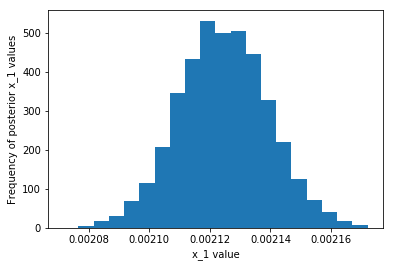

In [17]:
plt.hist(better_samples['x_1'],bins=20)
plt.xlabel('x_1 value')
plt.ylabel('Frequency of posterior x_1 values')
plt.show()

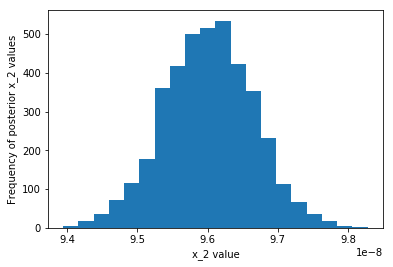

In [18]:
plt.hist(better_samples['x_2'],bins=20)
plt.xlabel('x_2 value')
plt.ylabel('Frequency of posterior x_2 values')
plt.show()

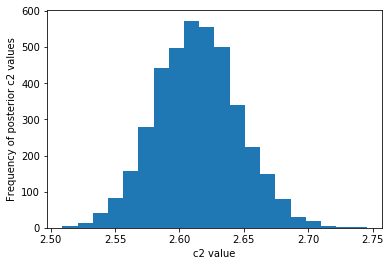

In [19]:
plt.hist(better_samples['c2'],bins=20)
plt.xlabel('c2 value')
plt.ylabel('Frequency of posterior c2 values')
plt.show()

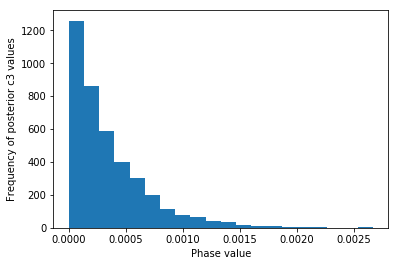

In [20]:
plt.hist(better_samples['c3'],bins=20)
plt.xlabel('Phase value')
plt.ylabel('Frequency of posterior c3 values')
plt.show()

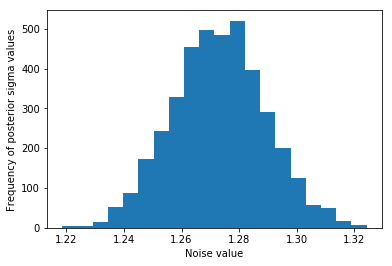

In [21]:
plt.hist(better_samples['sigma'],bins=20)
plt.xlabel('Noise value')
plt.ylabel('Frequency of posterior sigma values')
plt.show()

In [22]:
#determine strong probability of reaching 450ppm CO2
def first_index_gt(data_list, value):
    '''return the first index greater than value from a given list like object'''
    try:
        index = next(data[0] for data in enumerate(data_list) if data[1] > value)
        return index
    except StopIteration: return - 1
import datetime

#use above function to give days since observation
date_1 = datetime.datetime.strptime(data[0][3090], "%Y-%m-%d")
end_date = date_1 + datetime.timedelta(days=first_index_gt(lower_bound,450)*7)
print(end_date)

2035-03-17 00:00:00


In [23]:
#assign parameter values
c0 = np.mean(better_samples['intercept'])
x1 = np.mean(better_samples['x_1'])
x2 = np.mean(better_samples['x_2'])
c2 =  np.mean(better_samples['c2'])
c3 = np.mean(better_samples['c3'])
c4 = np.mean(better_samples['sigma'])
model_co2 = np.zeros(len(data))

#use model to predict observed values
for i in range(0,len(data)):
    t = data[2][i]
    mean = c0 +x1*t + x2*t*t + c2*np.cos((2*np.pi*t)/365.25+c3)
    model_co2[i] = stats.norm.rvs(mean,c4)
                                                                                                                                        

In [24]:
#use a function to determine R^2
from sklearn.metrics import r2_score
r2_score(data[1],model_co2)

0.9955928098852185